# Case-by-case analysis
This notebook demonstrates how to visualize which model managed to solve which test-case how often.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
directory = "../data/"

collection = []
for filename in os.listdir(directory):
    if filename.endswith("_results.jsonl"):
        print(filename)
        df = pd.read_json(directory + filename, lines=True)
        df['model'] = filename.replace(".jsonl_results.jsonl", "").replace("samples_", "")
        collection.append(df)

df = pd.concat(collection)

samples_gemini-pro.jsonl_results.jsonl
samples_reference.jsonl_results.jsonl
samples_gpt-3.5-turbo-1106.jsonl_results.jsonl
samples_claude-3-opus-20240229.jsonl_results.jsonl
samples_codellama.jsonl_results.jsonl
samples_gpt-4-turbo-2024-04-09.jsonl_results.jsonl
samples_gpt-4-1106-preview.jsonl_results.jsonl


In [3]:
df

,task_id,completion,full_response,result,passed,model
0,../test_cases/apply_otsu_threshold_and_count_p...,\ndef apply_otsu_threshold_and_count_postiive_...,```python\ndef apply_otsu_threshold_and_count_...,failed: OpenCV(4.9.0) d:\a\opencv-python\openc...,False,gemini-pro
1,../test_cases/binary_closing.ipynb,"\ndef binary_closing(binary_image, radius:int=...","```python\ndef binary_closing(binary_image, ra...",failed:,False,gemini-pro
2,../test_cases/binary_skeleton.ipynb,"\ndef binary_skeleton(binary_image):\n """"""\...",```python\ndef binary_skeleton(binary_image):\...,failed: The truth value of an array with more ...,False,gemini-pro
3,../test_cases/bland_altman.ipynb,"\ndef bland_altman(dataframe, column1:str, col...","```python\ndef bland_altman(dataframe, column1...",passed,True,gemini-pro
4,../test_cases/combine_columns_of_tables.ipynb,"\ndef combine_columns_of_tables(dataframe1, da...",```python\ndef combine_columns_of_tables(dataf...,passed,True,gemini-pro
...,...,...,...,...,...,...
565,../test_cases/workflow_batch_process_folder_me...,\n# Plan\n# 1. Use os library to list all file...,```python\n# Plan\n# 1. Use os library to list...,failed: 'label',False,gpt-4-1106-preview
566,../test_cases/workflow_segmentation_counting.i...,\n# Plan:\n# 1. Compute the average intensity ...,```python\n# Plan:\n# 1. Compute the average i...,failed:,False,gpt-4-1106-preview
567,../test_cases/workflow_segmentation_measuremen...,\n# Import the necessary libraries\nimport num...,```python\n# Import the necessary libraries\ni...,passed,True,gpt-4-1106-preview
568,../test_cases/workflow_segment_measure_umap.ipynb,\n# Plan:\n# 1. Threshold the image to segment...,```python\n# Plan:\n# 1. Threshold the image t...,passed,True,gpt-4-1106-preview


In [4]:
# Ensure the 'passed' column is boolean for correct processing.
df['passed'] = df['passed'].astype(bool)
# shorten task name
df['task_id'] = [str(t).replace("../test_cases/", "").replace(".ipynb","") for t in df['task_id']]

# Pivot the dataframe to count True 'passed' values for each model-task combination.
pivot_df = df.pivot_table(index='task_id', columns='model', values='passed', aggfunc='mean', fill_value=0)

# Reset the index if 'task_id' needs to be a column instead of an index
pivot_df.reset_index(inplace=True)

# Apply formatting to display only two digits after the decimal point for all columns after the first (task_id column)
pivot_df = pivot_df.round(2)

# Show the transformation result (for verification)
def colorize(styler):
    styler.background_gradient(axis=None, cmap="PiYG")
    return styler

# Apply the formatting within the styling function using .format
pivot_df.style.pipe(colorize).format("{:.1f}", subset=pivot_df.columns[1:])

model,task_id,claude-3-opus-20240229,codellama,gemini-pro,gpt-3.5-turbo-1106,gpt-4-1106-preview,gpt-4-turbo-2024-04-09,reference
0,apply_otsu_threshold_and_count_postiive_pixels,0.0,0.0,0.1,0.0,0.0,0.0,1.0
1,binary_closing,1.0,0.0,0.0,0.1,0.6,0.4,1.0
2,binary_skeleton,0.6,0.1,0.0,0.1,0.9,0.8,1.0
3,bland_altman,1.0,0.2,0.6,1.0,1.0,1.0,1.0
4,combine_columns_of_tables,0.1,0.1,0.7,0.9,1.0,0.8,1.0
5,convex_hull_measure_area,1.0,0.2,0.2,0.8,0.7,0.9,1.0
6,convolve_images,0.7,0.0,0.0,0.1,0.4,0.5,1.0
7,count_number_of_touching_neighbors,0.1,0.0,0.0,0.1,0.2,0.6,1.0
8,count_objects_over_time,0.6,0.1,0.2,0.1,0.5,0.5,1.0
9,count_overlapping_regions,1.0,0.0,0.0,0.4,1.0,1.0,1.0


0.13.2


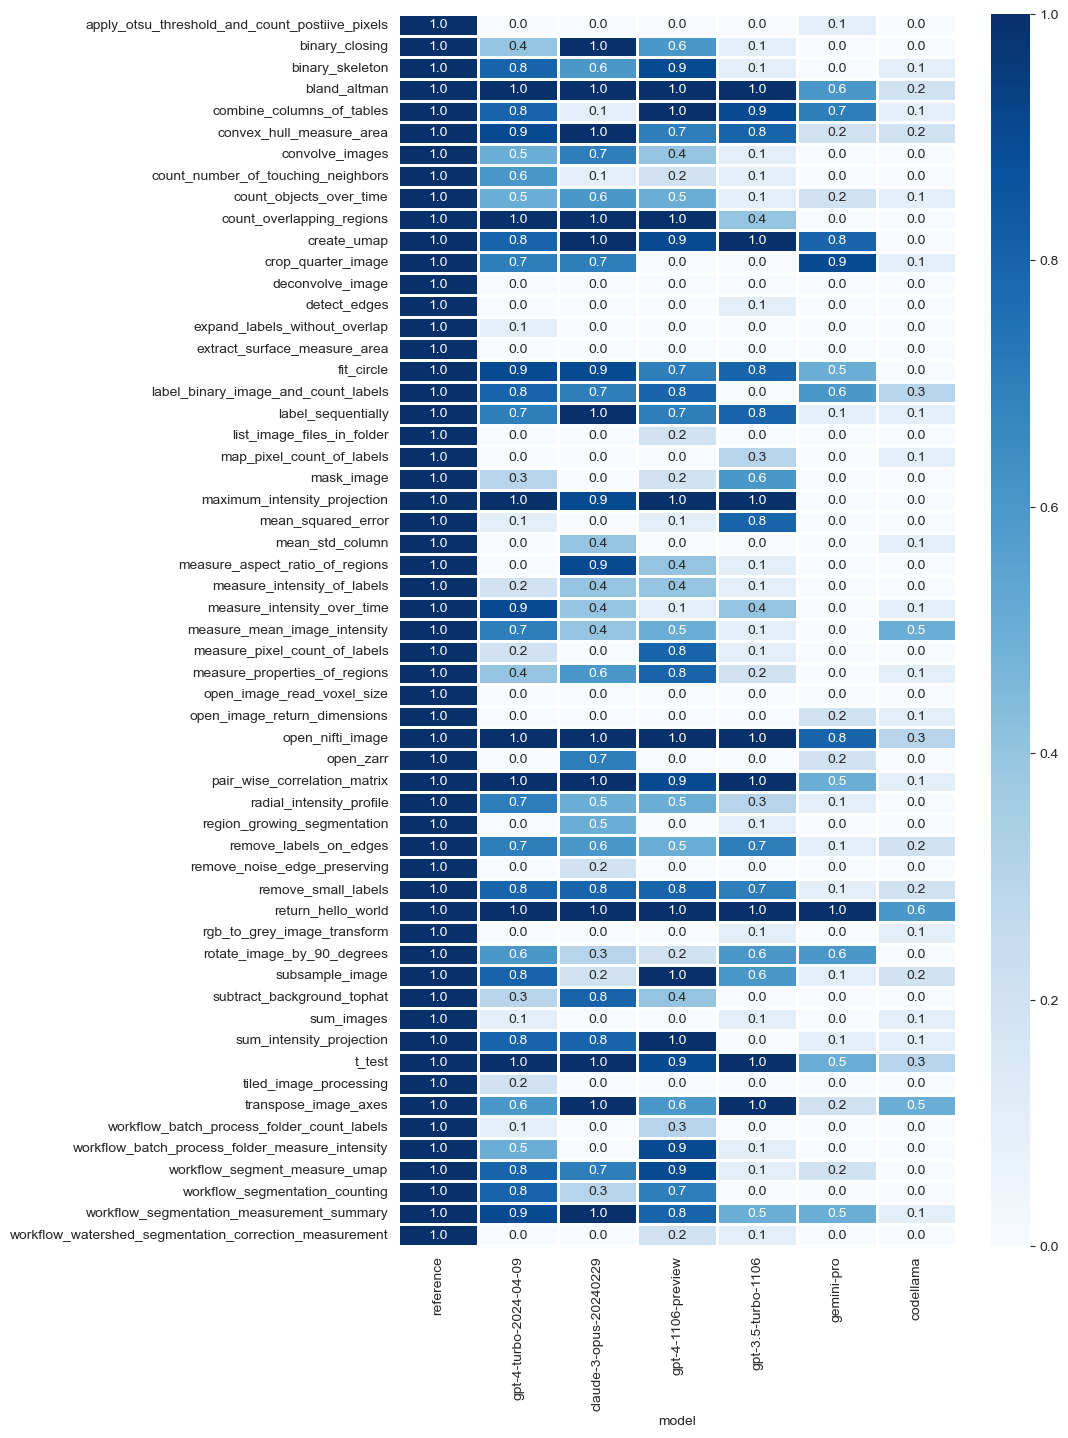

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

print(sns.__version__)
sns.set_style("white")

df = pivot_df

# Separate the numerical data for plotting and the string column for y-axis labels
numerical_data = df.select_dtypes(include=[np.number])
mean_values = numerical_data.mean().sort_values(ascending=False)

# Reorder columns in numerical_data based on sorted mean values
numerical_data = numerical_data[mean_values.index]

str_column_values = df['task_id']  # Replace 'str_column' with the actual column name


# Plotting
fig = plt.figure(figsize=(9,16))
sns.heatmap(numerical_data, annot=True, linewidths=1, yticklabels=str_column_values, fmt=".1f", cbar_kws={'shrink': 1, 'aspect': 2*16}, cmap="Blues")

plt.savefig("../docs/paper/performance_per_task", bbox_inches="tight", dpi=300)
plt.show()

In [52]:
pivot_df.describe()

model,claude-3-opus-20240229,codellama,gemini-pro,gpt-3.5-turbo-1106,gpt-4-1106-preview,gpt-4-turbo-2024-04-09,reference
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.0
mean,0.470175,0.087719,0.173684,0.333333,0.464912,0.473684,1.0
std,0.402210,0.136369,0.275504,0.379065,0.386602,0.381504,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,0.500000,0.000000,0.000000,0.100000,0.500000,0.500000,1.0
75%,0.900000,0.100000,0.200000,0.700000,0.800000,0.800000,1.0
max,1.000000,0.600000,1.000000,1.000000,1.000000,1.000000,1.0


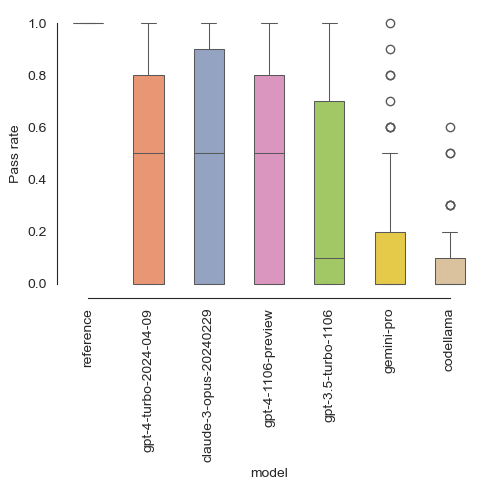

In [56]:
# Assuming pivot_df has 'task_id' as a non-numerical column and the rest are numerical and need to be plotted
numerical_data = pivot_df.drop(columns=['task_id'])

# Calculate the mean of each column and sort these means in descending order
mean_values = numerical_data.mean().sort_values(ascending=False)

# Reorder columns in numerical_data based on sorted mean values
ordered_numerical_data = numerical_data[mean_values.index]

# Plotting the boxplot with reordered columns
plt.figure(figsize=(5, 5))
#boxplot = plt.boxplot(ordered_numerical_data, patch_artist=True, labels=ordered_numerical_data.columns)

boxplot = sns.boxplot(ordered_numerical_data, palette= "Set2", width=0.5, linewidth=0.75)
sns.despine(offset=1, trim=True);
# Adding colors
# colors = ['lightblue'] * len(ordered_numerical_data.columns)
#for patch, color in zip(boxplot['boxes'], colors):
#    patch.set_facecolor(color)

# plt.title('Pass rate for generated BIA Python code')
plt.xticks(rotation=90)  # Rotate labels to avoid overlap
plt.ylabel('Pass rate')  # Optionally adjust the label to suit the data context
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

plt.savefig("../docs/paper/pass_rate_llms.png")
plt.show()

with open("model_order.txt", 'w') as f:
    for item in ordered_numerical_data.columns:
        f.write(str(item) + '\n')